# Time Series Data Manipulation and Trends

## Objectives

- Understand the use case for time series data
- Manipulate datetime objects
- Understand different resampling techniques
- Identify different trends of a time series data
- Identify when a time series is stationary
- Transform a time series to a stationary one

## What Are Time Series Data?

> We can say data is a **time series** when the temporal information is a key focus of the data.

Data in a time series can stem from historical data or data that is dependent on past values.

### Some Examples

- Stock prices
- Atmospheric changes over the course of decades
- Audio samples
- Heart rate data

### Uses for Time Series

- Understand some underlying process
- Forecasting (what we'll mostly focus on)
- Imputation (filling missing "past" data)
- Anomaly detection

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

## Example Data

This data comes from [Google Trends](https://trends.google.com). Try entering a search term! The little question-mark icon on the new page explains how to interpret the numbers.

We also have a few Google Trends here to explore:

In [2]:
# Define a function that will help us load and clean each dataset

def load_trend(trend_name='football', country_code='us'):
    df = pd.read_csv('data/google-trends_'
                     + trend_name + '_'
                     + country_code
                     + '.csv').iloc[1:, :]
    df.columns = ['counts']
    df['counts'] = df['counts'].str.replace('<1', '0').astype(int)
    return df

In [3]:
# Let's load up one...
load_trend(trend_name='data-science').head(10)

,counts
2004-01,17
2004-02,5
2004-03,11
2004-04,10
2004-05,8
2004-06,8
2004-07,8
2004-08,7
2004-09,14
2004-10,10


In [4]:
trends = [
    {'trend_name': 'data-science', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'uk'},
    {'trend_name': 'coronavirus', 'country_code': 'us'},
    {'trend_name': 'trump', 'country_code': 'us'},
    {'trend_name': 'taxes', 'country_code': 'us'},
    {'trend_name': 'avengers', 'country_code': 'us'}
]

### Guess That Time Series!

Given the trends above and the below plots, can you match them up?

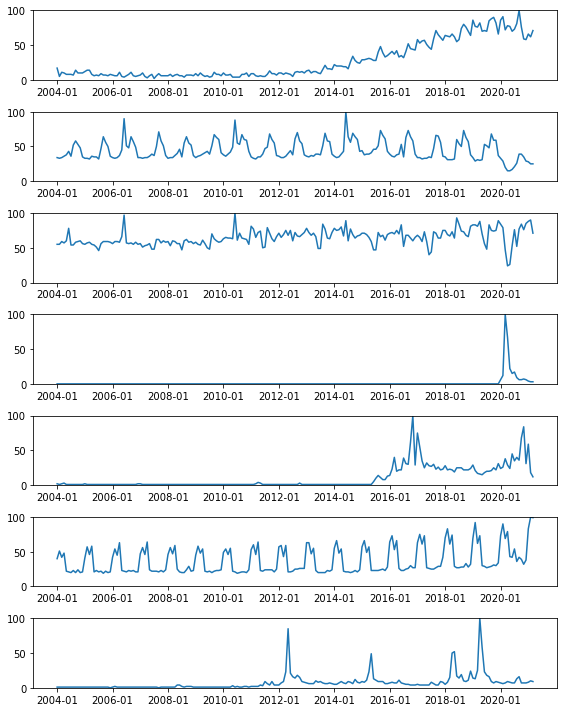

In [5]:
trend_dfs = [load_trend(**trend) for trend in trends]

fig, axs = plt.subplots(len(trend_dfs), 1, figsize=(8, 10))
plt.tight_layout()
for i, trend_df in enumerate(trend_dfs):
    ax = axs[i]
#     ax.set_title(str(trends[i]))
    ax.plot(np.array(trend_df.index), trend_df['counts'])
    ticks = ax.get_xticks()
    ax.set_ylim((0, 100))
    ax.set_xticks([tick for tick in ticks if tick%24 == 0])
    
# Trends:
# data science, US football, UK football, coronavirus, trump, taxes, avengers

This may seem like a silly exercise - but by trying this out, you can start to see patterns, and discern how different time series all exhibit different trends! This understanding of trends/patterns is useful, as we'll start to understand that certain time series are easier to model than others.

## Set Up - Datetime Data

When we checked out the one example of Google trends data, you may have noticed that the date/time column was set as the **index** of the series. Setting the date/time as the index is a very easy way to make sure pandas recognizes our data as date/time-dependent, and will be vital when we get to the point that we're forecasting our data.

### Two Ways to Set a Datetime Index:

1. Make sure the column containing the date/time details is considered a `datetime` type in pandas, then set it as the index.
2. Have pandas `parse_dates` when reading in the data, and set it as the index right then!

Let's showcase both - we'll use a file called `Historical_Data` in the data folder

In [6]:
# V1: Read in data normally:
df1 = pd.read_csv('data/Historical_Data.csv')

In [7]:
df1.head()

,Date,Article_ID,Country_Code,Sold_Units
0,20170817,1132,AT,1
1,20170818,1132,AT,1
2,20170821,1132,AT,1
3,20170822,1132,AT,1
4,20170906,1132,AT,1


In [9]:
# Use pandas' to_datetime function, format="%Y%m%d" 
df1['Date'] = pd.to_datetime(df1['Date'], format='%Y%m%d')

In [11]:
# Check our work
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4849 entries, 2017-08-17 to 2019-01-30
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Article_ID    4849 non-null   int64 
 1   Country_Code  4849 non-null   object
 2   Sold_Units    4849 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 151.5+ KB


In [10]:
# Now set the index
df1 = df1.set_index('Date')
df1.head()

,Article_ID,Country_Code,Sold_Units
Date,,,
2017-08-17,1132,AT,1
2017-08-18,1132,AT,1
2017-08-21,1132,AT,1
2017-08-22,1132,AT,1
2017-09-06,1132,AT,1


In [13]:
# V2: Do all the work in read_csv, using set_index and parse_dates
df2 = pd.read_csv('data/Historical_Data.csv',
                 parse_dates = True,
                 index_col = 'Date')

In [14]:
# Check our work
df2.head()

,Article_ID,Country_Code,Sold_Units
Date,,,
2017-08-17,1132,AT,1
2017-08-18,1132,AT,1
2017-08-21,1132,AT,1
2017-08-22,1132,AT,1
2017-09-06,1132,AT,1


In [15]:
# Make a copy of one of these to keep working with!
df = df1.copy()

## Investigating Time Series with Datetime Indexes

Datetime objects include aspects of the date as attributes, like month and year:

In [16]:
# Check out the first index item
df.index[0]

Timestamp('2017-08-17 00:00:00')

In [17]:
# That first index item has a month attribute
df.index[0].month

8

In [18]:
# And a year attribute
df.index[0].year

2017

In [19]:
# And a day attribute!
df.index[0].day

17

We can also use the date to directly slice the DataFrame

In [20]:
# Let's make sure our data is sorted by date using sort_index() first
df = df.sort_index()

In [23]:
# Only data after 2019
df['2019':]

,Article_ID,Country_Code,Sold_Units
Date,,,
2019-01-01,332,FI,1
2019-01-01,3448,SE,2
2019-01-01,5984,FI,2
2019-01-01,332,SE,3
2019-01-01,5972,SE,3
...,...,...,...
2019-02-13,1132,AT,2
2019-02-13,1132,FR,1
2019-02-13,332,FI,3


In [24]:
# Only data from this time period
df['2017-09-01':'2017-10-01']

,Article_ID,Country_Code,Sold_Units
Date,,,
2017-09-01,362,FI,1
2017-09-01,362,FR,1
2017-09-01,3417,AT,1
2017-09-01,5984,FI,1
2017-09-01,332,SE,2
...,...,...,...
2017-10-01,1132,FR,1
2017-10-01,5972,SE,1
2017-10-01,3446,SE,1


We can easily see now whether more products are sold, for example, during winter months. For simplicity we'll say that winter comprises the months of January, February, and March.

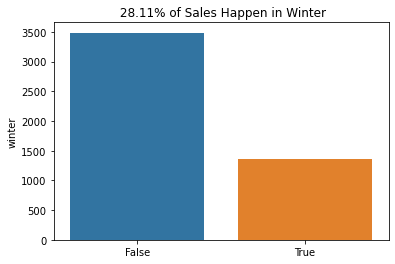

In [25]:
fig, ax = plt.subplots()

df['month'] = df.index
df['month'] = df['month'].apply(lambda x: x.month)
df['winter'] = df['month'].apply(lambda x: 1 <= x <= 3)

sum_ratio = df['winter'].value_counts()[1]/len(df)

x = df['winter'].value_counts().index
y = df['winter'].value_counts()
sns.barplot(x=x, y=y)

ax.set_title(f'{sum_ratio: 0.2%} of Sales Happen in Winter');

## Resampling Techniques

With a Datetime index, we also have new abilities, such as **resampling**.

> **Resampling** allows us to convert the time series into a particular frequency

Resources:
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling

There are many possible units for resampling, each with its own alias:

<table style="display: inline-block">
    <caption style="text-align: center"><strong>TIME SERIES OFFSET ALIASES</strong></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>B</td><td>business day frequency</td></tr>
<tr><td>C</td><td>custom business day frequency (experimental)</td></tr>
<tr><td>D</td><td>calendar day frequency</td></tr>
<tr><td>W</td><td>weekly frequency</td></tr>
<tr><td>M</td><td>month end frequency</td></tr>
<tr><td>SM</td><td>semi-month end frequency (15th and end of month)</td></tr>
<tr><td>BM</td><td>business month end frequency</td></tr>
<tr><td>CBM</td><td>custom business month end frequency</td></tr>
<tr><td>MS</td><td>month start frequency</td></tr>
<tr><td>SMS</td><td>semi-month start frequency (1st and 15th)</td></tr>
<tr><td>BMS</td><td>business month start frequency</td></tr>
<tr><td>CBMS</td><td>custom business month start frequency</td></tr>
<tr><td>Q</td><td>quarter end frequency</td></tr>
<tr><td></td><td><font color=white>intentionally left blank</font></td></tr></table>

<table style="display: inline-block; margin-left: 40px">
<caption style="text-align: center"></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>BQ</td><td>business quarter endfrequency</td></tr>
<tr><td>QS</td><td>quarter start frequency</td></tr>
<tr><td>BQS</td><td>business quarter start frequency</td></tr>
<tr><td>A</td><td>year end frequency</td></tr>
<tr><td>BA</td><td>business year end frequency</td></tr>
<tr><td>AS</td><td>year start frequency</td></tr>
<tr><td>BAS</td><td>business year start frequency</td></tr>
<tr><td>BH</td><td>business hour frequency</td></tr>
<tr><td>H</td><td>hourly frequency</td></tr>
<tr><td>T, min</td><td>minutely frequency</td></tr>
<tr><td>S</td><td>secondly frequency</td></tr>
<tr><td>L, ms</td><td>milliseconds</td></tr>
<tr><td>U, us</td><td>microseconds</td></tr>
<tr><td>N</td><td>nanoseconds</td></tr></table>

When resampling, we have to provide a rule to resample by, and an **aggregate function**.

Let's explore the number of sales reported per week - what code should we use?

In [28]:
# Run our .resample on df
# Notice how this doesn't render anything -- need that aggregator!
df.resample('W')

**To upsample** is to increase the frequency of the data of interest.  
**To downsample** is to decrease the frequency of the data of interest.

For our purposes, we will downsample to weekly, and sum the number of sold units per day.

In [29]:
# Downsample to weekly, then sum the number of Sold_Units
df_resampled = df.resample('W').sum()['Sold_Units']

In [31]:
df_resampled

Date
2017-01-01      1
2017-01-08     33
2017-01-15     38
2017-01-22     30
2017-01-29     30
             ... 
2019-01-20    176
2019-01-27    181
2019-02-03    191
2019-02-10    178
2019-02-17     60
Freq: W-SUN, Name: Sold_Units, Length: 112, dtype: int64

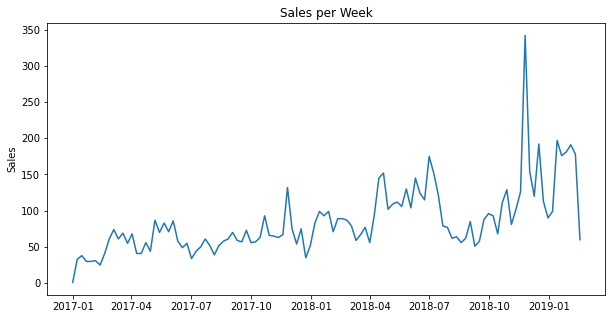

In [32]:
# Plot our new df_resampled
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_resampled)
ax.set_title('Sales per Week')
ax.set_ylabel('Sales');

## Filling Techniques

What happens when we have gaps in our time series?

To explore this, let's resample to count the number of sold units per day. We can replace `0`s with `np.nan`, since a 0 indicates we have a gap where nothing was sold.

In [36]:
# Count the number of sold units per day
df_count = df.resample('D')['Sold_Units'].count()
df_count
# And use .replace() to render 0s as np.nan
df_count = df_count.replace(0, np.nan)
df_count

Date
2017-01-01     1.0
2017-01-02     2.0
2017-01-03     3.0
2017-01-04     4.0
2017-01-05     4.0
              ... 
2019-02-09    11.0
2019-02-10    11.0
2019-02-11    10.0
2019-02-12     8.0
2019-02-13     8.0
Freq: D, Name: Sold_Units, Length: 774, dtype: float64

In [37]:
# How many nulls?
df_count.isna().sum()

2

In [38]:
# What are they?
df_count.loc[df_count.isna()]

Date
2017-06-17   NaN
2017-12-21   NaN
Freq: 187D, Name: Sold_Units, dtype: float64

In [39]:
# Let's slice to explore the first one
gap = df_count['2017-06-15':'2017-06-19']

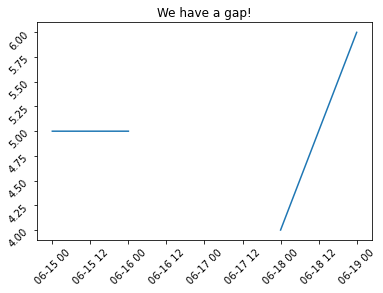

In [40]:
# Plot it!
fig, ax = plt.subplots()
ax.plot(gap)
ax.tick_params(rotation=45)
ax.set_title('We have a gap!');

In general, the datetime object allows us several options of how to fill those gaps:

### `.bfill()`

The `.bfill()` time-series method will take known values and project them *backward* to fill gaps.

In [44]:
# Show our original gap
gap.head()

Date
2017-06-15    5.0
2017-06-16    5.0
2017-06-17    NaN
2017-06-18    4.0
2017-06-19    6.0
Freq: D, Name: Sold_Units, dtype: float64

In [45]:
# Now check out with bfill
gap.bfill().head()

Date
2017-06-15    5.0
2017-06-16    5.0
2017-06-17    4.0
2017-06-18    4.0
2017-06-19    6.0
Freq: D, Name: Sold_Units, dtype: float64

###  `.ffill()`

The `.ffill()` time-series method will take known values and project them *forward* to fill gaps. 

In [46]:
# Now check out with ffill
gap.ffill().head()

Date
2017-06-15    5.0
2017-06-16    5.0
2017-06-17    5.0
2017-06-18    4.0
2017-06-19    6.0
Freq: D, Name: Sold_Units, dtype: float64

### `.interpolate()`

The `.interpolate()` time-series method will simply connect the endpoints that define a gap with a straight line.

In [47]:
# Now check out with interpolate
gap.interpolate().head()

Date
2017-06-15    5.0
2017-06-16    5.0
2017-06-17    4.5
2017-06-18    4.0
2017-06-19    6.0
Freq: D, Name: Sold_Units, dtype: float64

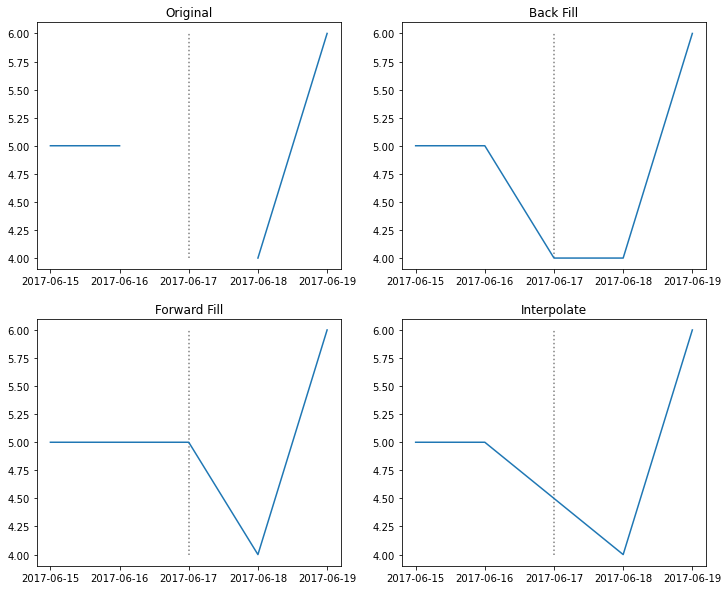

In [48]:
# Visualize all four:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 10))
ax1.plot(gap)
ax1.set_title('Original')

ax2.plot(gap.bfill())
ax2.set_title('Back Fill')

ax3.plot(gap.ffill())
ax3.set_title('Forward Fill')

ax4.plot(gap.interpolate())
ax4.set_title('Interpolate')

for ax in [ax1, ax2, ax3, ax4]:
    ax.vlines('2017-06-17', 4, 6, color='gray', linestyles='dotted')
    ax.set_xticks(gap.index);

----

# Components of Time Series Data

A time series in general is supposed to be affected by four main components, which can be separated from the observed data: *Trend, Cyclical, Seasonal and Irregular* components.

## Trend 

> The long term movement of a time series. 

For example, series relating to population growth, number of houses in a city etc. show upward trend.

## Seasonal

> Fluctuation in the data set that follow a regular pattern due to outside influences

For example sales of ice-cream increase in summer, or daily web traffic.

## Cyclical

> When data exhibit rises and falls that are not of fixed period

Think of business cycles which usually last several years, but where the length of the current cycle is unknown beforehand.

> **NOTE:** Many people confuse cyclic behavior with seasonal behavior, but they are really quite different. If the fluctuations are not of fixed period then they are cyclic; if the period is unchanging and associated with some aspect of the calendar, then the pattern is seasonal.

## Irregular

> Caused by unpredictable influences, which are not regular and also do not repeat in a particular pattern. 

These variations are caused by incidences that come at random intervals. There is no defined statistical technique for measuring random fluctuations in a time series.

# Stationarity

When building our models, we will want to account for these patterns somehow. If a time series has predictable trends in its mean and variance, we want to build that into our modeling understanding, leaving only the randomness behind! 

> A **stationary time series** is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. 

Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!

It may seem counterintuitive that, for modeling purposes, we want our time series not to be a function of time! But the basic idea is the familiar one that we want our datapoints to be mutually *independent*. For more on this topic, see [here](https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary).

## Criteria for a Stationary Time Series

- The series' **mean** is **not** a function of time
![https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Mean_nonstationary.png](images/Mean_nonstationary.png)

- The series' **variance** is **not** a function of time (heteroscedacity)
![https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Var_nonstationary.png](images/Var_nonstationary.png)

- The series' **covariance** is **not** a function of time
![https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Cov_nonstationary.png](images/Cov_nonstationary.png)

> Images from [https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

To summarize:

![Examples of stationary and non-stationary processes](https://miro.medium.com/max/1400/1*tkx0_wwQ2JT7pSlTeg4yzg.png)


[Image Source: a useful blog post!](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

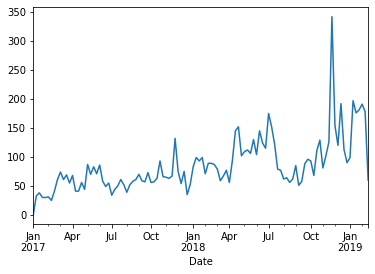

In [49]:
# Check out our df_resampled
df_resampled.plot();

#### Discuss: Do you think the data is stationary? Why/why not?

- No
- Why not? slight upward trend, non-stationary variance aka heteroskedasticity


Let's try decomposing our time series to explore it!

[Documentation](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

In [50]:
# Import seasonal_decompose from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose 

In [51]:
# Run the seasonal_decompose on df_resampled
# Additive or multiplicative?
decomposition = seasonal_decompose(df_resampled)

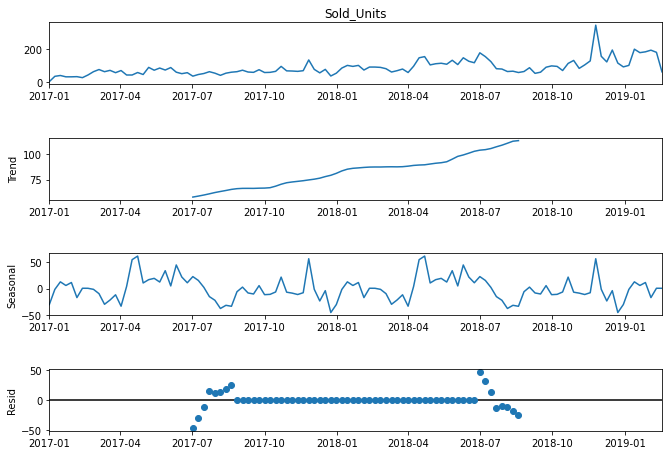

In [52]:
# This is most useful for the plots! 
res = decomposition.plot()
# Using these to make the plots bigger
res.set_figheight(7)
res.set_figwidth(10)

### The Augmented Dickey Fuller Test - a Hypothesis Test for Stationarity! (kind of)

[Documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) for the Dickey-Fuller test in StatsModels
- Unit root...? https://www.statisticshowto.com/unit-root/
- Potentially also useful: https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/

Write out our null and alternate hypotheses (remember these??)

$H_0$: time-series is not stationary

$H_a$: time-series is stationary

In [53]:
# Import adfuller from statsmodels
from statsmodels.tsa.stattools import adfuller

In [54]:
# Check out the results
df_results = adfuller(df_resampled)

In [55]:
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(df_results[0:4], 
                     index=['Test Statistic', 'p-value',
                            '# Lags Used', '# Observations Used']
)

for key,value in df_results[4].items():
    dfoutput[f'Critical Value ({key})'] = value
    
display(dfoutput)

Test Statistic           -1.753302
p-value                   0.403880
# Lags Used               6.000000
# Observations Used     105.000000
Critical Value (1%)      -3.494220
Critical Value (5%)      -2.889485
Critical Value (10%)     -2.581676
dtype: float64

#### Discuss: Do you think it's stationary?

- Fail to reject null
- AKA still not stationary


## Getting a Stationary Time Series 

Let's try out seeing how we can get a time series that is non-stationary to something we can make predictions on.

We'll discuss:
- subtracting a rolling mean
- differencing
- other transformations, like log or square-root

### Subtract the Rolling Mean

This can allow us to look at fluctuations from the overall "smoother" trend.

#### Let's Check Out Our Rolling Statistics

These calculate a statistic over a window of past data points (aka over a time period)

In [57]:
# Just using .rolling by itself doesn't render anything
# Also, let's discuss - what window makes sense here?
df_resampled.rolling(window=4)

Rolling [window=4,center=False,axis=0]

In [58]:
# Now check the mean on that rolling window
rollmean = df_resampled.rolling(window=4).mean()

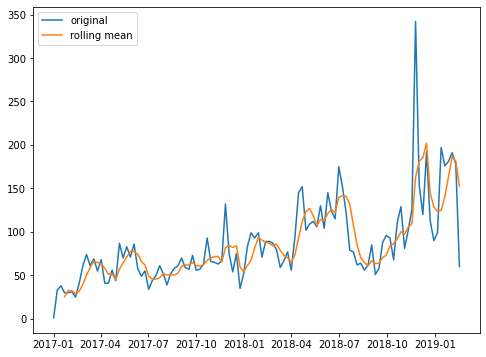

In [59]:
# Plot it
plt.figure(figsize=(8,6))
plt.plot(df_resampled, label='original')
plt.plot(df_resampled.rolling(window=4).mean(), label = 'rolling mean')
plt.legend();

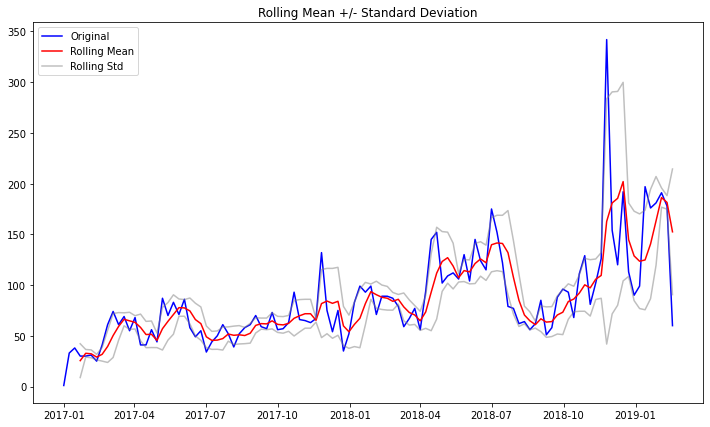

In [61]:
# Even nicer plot
# We'll add in a rolling standard deviation!
rollstd = df_resampled.rolling(window=4).std()

plt.figure(figsize=(12, 7))
plt.plot(df_resampled, color='blue', label='Original')
plt.plot(rollmean, color='red', label='Rolling Mean')
plt.plot(rollmean+rollstd, color='gray', label='Rolling Std', alpha=.5)
plt.plot(rollmean-rollstd, color='gray', alpha=.5)

plt.legend(loc='best')
plt.title('Rolling Mean +/- Standard Deviation')
plt.show(block=False)

By subtracting the rolling mean from our original data, we can try to make the data more stationary.

Let's try it out:

In [62]:
# Subtract rollmean from df_resampled
data_minus_rollmean = df_resampled-rollmean

In [63]:
# Drop the NaN values from timeseries calculated above 
# (the first few values didn't have a rolling mean)
data_minus_rollmean.dropna(inplace=True)

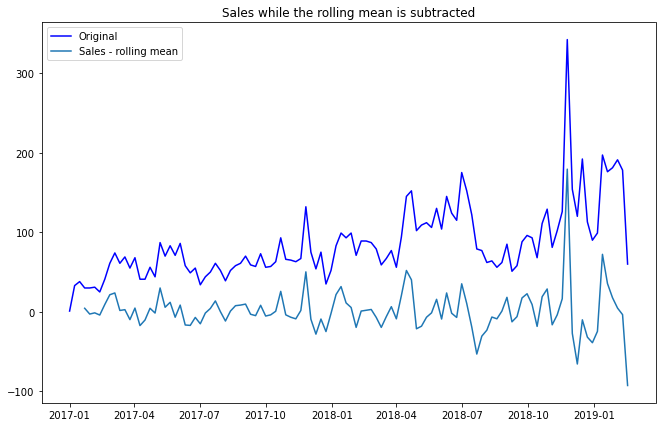

In [64]:
fig = plt.figure(figsize=(11, 7))
plt.plot(df_resampled, color='blue', label='Original')
plt.plot(data_minus_rollmean, label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

#### Discuss: Is it stationary?

- More stationary, now centered around 0, stationary mean
- staionary? no, very non-stationary variance


### Differencing

One of the most common ways of trying to convert a non-stationary series into a stationary one is to take as a new series *the differences in consecutive terms*. This is easily effected by means of the `.diff()` method of NumPy arrays.

In [67]:
# Check out running .diff on df_resampled
# Let's do this as new columns on a copy of df_resampled
df_diffs = pd.DataFrame(df_resampled)

df_diffs['Diff 1'] = df_resampled.diff()
df_diffs.head()

,Sold_Units,Diff 1
Date,,
2017-01-01,1,NaN
2017-01-08,33,32.0
2017-01-15,38,5.0
2017-01-22,30,-8.0
2017-01-29,30,0.0


In [68]:
# Can do more than one difference!
df_diffs['Diff 2'] = df_resampled.diff(2)

df_diffs

,Sold_Units,Diff 1,Diff 2
Date,,,
2017-01-01,1,NaN,NaN
2017-01-08,33,32.0,NaN
2017-01-15,38,5.0,37.0
2017-01-22,30,-8.0,-3.0
2017-01-29,30,0.0,-8.0
...,...,...,...
2019-01-20,176,-21.0,77.0
2019-01-27,181,5.0,-16.0
2019-02-03,191,10.0,15.0


### Sidenote: `pd.Series.diff()` vs. `np.diff()`

**Be careful! These two are *not* the same.** The former takes as a parameter the number of periods (i.e. the width of the gap) to use in constructing the differences. The latter takes as a parameter the *order* of the differences.

In [69]:
arr = pd.Series(np.arange(10)**2)
print(f"Original: {arr.values}")
print(f"pd.Series.diff(): {arr.diff(2).values}")
print(f"np.diff(): {np.diff(arr, 2)}")

Original: [ 0  1  4  9 16 25 36 49 64 81]
pd.Series.diff(): [nan nan  4.  8. 12. 16. 20. 24. 28. 32.]
np.diff(): [2 2 2 2 2 2 2 2]


End of sidenote.

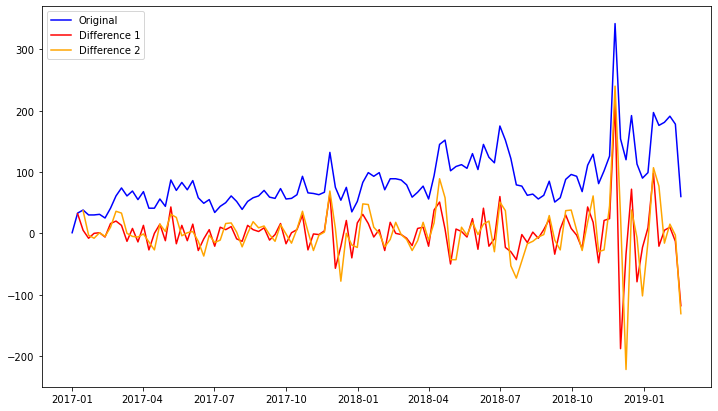

In [70]:
# Now let's check out our differenced data
plt.figure(figsize=(12, 7))
plt.plot(df_resampled, color='blue', label='Original')
plt.plot(df_diffs['Diff 1'], color='red', label='Difference 1')
plt.plot(df_diffs['Diff 2'], color='orange', label='Difference 2')

plt.legend(loc='best');

#### Discuss: Are either of these stationary?

- no


### Other Methods: Log Transformation, Square Root Transformation

Penalize higher values more 

Useful when:

- Clear & significant positive trend but maybe not linear
- Certain heteroscedasticity

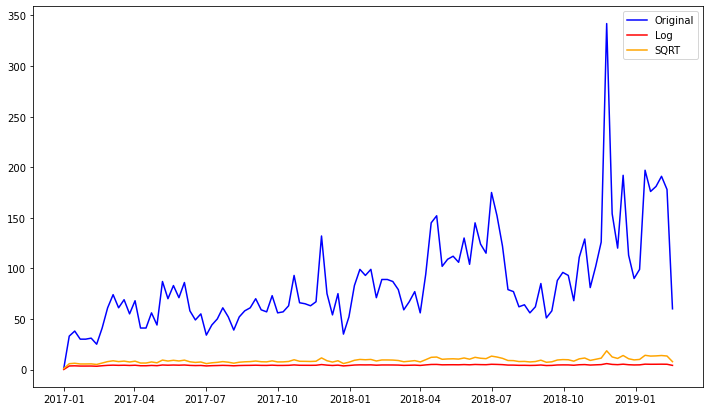

In [71]:
# Now let's check out our differenced data
plt.figure(figsize=(12, 7))
plt.plot(df_resampled, color='blue', label='Original')
plt.plot(np.log(df_resampled), color='red', label='Log')
plt.plot(np.sqrt(df_resampled), color='orange', label='SQRT')

plt.legend(loc='best');

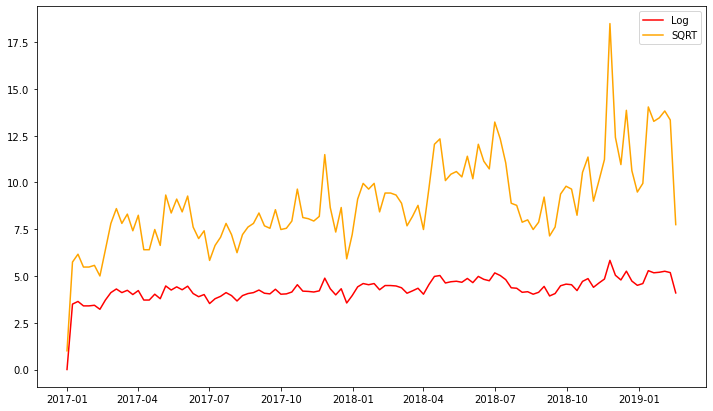

In [72]:
# Let's zoom in
# Now let's check out our differenced data
plt.figure(figsize=(12, 7))

plt.plot(np.log(df_resampled), color='red', label='Log')
plt.plot(np.sqrt(df_resampled), color='orange', label='SQRT')

plt.legend(loc='best');

#### Discuss: Are either of these stationary?

- log looks pretty good 


In [73]:
adfuller(np.log(df_resampled))

(-3.1674680262875508,
 0.021946685884493354,
 6,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 51.150257034356)

## Review: Why do we want to get a stationary series?

- We in a way want to get rid of the temporal dependence: leave just the "noise"
- That "noise" can then be modeled based on other features!
- Think of "stationary" like "independence"

-----

# Extra Resources:

## Types of Trends

### No Trend

<img src="images/no-trend.png" width=600>

### Linear Trend (also known as Additive)

<img src="images/linear_trend-upward.png" width=550>

<img src="images/linear_trend-downward.png" width=550>

### Exponential (also known as Multiplicative)

<img src="images/exponential_trend.png" width=550>

### Seasonal

<img src="images/periodic_trend-temperature.png" width=550>

<img src="images/periodic_trend-miles.png" width=550>